# Failure Prediction PJT

## Machine Learning 프로젝트 수행을 위한 코드 구조화
(분류, 회귀 Task)

### 템플릿 코드 생성 for ML Project
1. 필요한 라이브러리와 데이터를 불러옵니다.


2. EDA를 수행합니다. 이 때, EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. 전처리를 수행합니다. 이 때, 중요한 것은 feature engineering을 어떻게 하느냐 입니다.


4. 데이터 분할을 진행합니다. 이 때, train data와 test tada 간의 분포 차이가 없는 지 확인합니다.


5. 학습을 진행합니다. 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. Hyper-parameter tuning을 수행합니다. 원흐는 목표 성능이 나올 때 까지 진행합니다. 
   검증 단계를 통해, 지속적으로 overfitting이 되지 않게 주의하세요.


7. 최종 테스트를 진행합니다. 데이터 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.



## 1. 라이브러리, 데이터 불러오기

In [29]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# 일반적으로 정형데이터로 머신러닝 분석을 진행할 때는 아래 2개 모델을 돌려봅니다. 특히 RandomForest가 테스트하기 좋습니다.
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna


# Forge 추가 설치 사항
# conda install optuna
# conda install tpot-imblearn

In [2]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = 'fi' ## 'pca' or 'fi'
online = False ## use online training
sampling = 'hybrid' ## 'under' or 'over' or 'hybrid'

In [3]:
# 데이터를 불러옵니다.

# Related kaggle competitions
# Name: Bosch Production Line Performance
# Link: https://www.kaggle.com/competitions/bosch-production-line-performance

# train_cat_part = pd.read_csv('../input/bosch-production-line-performance/train_categorical.csv.zip',
#                             nrows=1000)
train_num_part = pd.read_csv('./bosch-production-line-performance/train_numeric.csv.zip',
                            nrows=1000)
train_date_part = pd.read_csv('./bosch-production-line-performance/train_date.csv.zip',
                             nrows=1000)

#print(train_cat_part.shape, train_num_part.shape, train_date_part.shape)
print(train_num_part.shape, train_date_part.shape)

(1000, 970) (1000, 1157)


In [4]:
# categorical data는 EDA 결과 분석에 큰 도움이 없어, 사용하지 않겠습니다.

# total = train_cat_part.count() * 0
# N = 0

# for chunk in pd.read_csv('../input/bosch-production-line-performance/train_categorical.csv.zip',
#                         chunksize=100000):  # chunksize가 클수록, 속도는 빨라지고 메모리 사용량이 늘어납니다.
    
#     total = total + chunk.isnull().sum()  # 전체 데이터의 column별 결측치 개수
#     N = N + len(chunk)  # 전체 데이터의 row 수
    
# display(total)
# print(N)
# usecols = total.index[(total / N) < 0.5] # train_categorical.csv에 있는 결측치가 50% 미만인 column들.
# usecols

In [5]:
# train_cat = pd.read_csv('../input/bosch-production-line-performance/train_categorical.csv.zip',
#                        usecols=usecols)
# train_cat

train_date.csv에서는 파생 변수를 만들어서 사용합니다.


1. 각 station별로 측정 시간이 모두 있거나, 없거나의 케이스만 존재한다.


- 데이터 중에서 station별로 하나의 column만 뽑아서 체크해도 괜찮다.

<br>


2. 각 station별로 시간이 모두 같지는 않다. 중간에 측정시간이 바뀌는 케이스도 있다.

- 데이터 별로 min, max값을 계산하면 된다.


<br>


- start_station : 해당 product가 처음으로 공정을 거친 station_name


- end_station : 해당 product가 마지막으로 공정을 거친 station_name


- time_diff : 해당 product가 처음 시작한 timestamp와 마지막으로 끝낸 timestamp의 차이 (공정에 걸린 시간)

In [6]:
# 1157 cols -> station 개수(S0 ~ S51)
# 1. column들이 나와있는 series를 하나 만듭니다.
train_date_part.count()
# 2. 그 series의 index를 뽑아서 가운데 _S0_ 를 뽑습니다.
train_date_part.count().reset_index()['index'].str.split('_', expand=True)[1]
# 3. 각 station별로 하나씩만 남깁니다. + Id column 제거
train_date_part.count().reset_index()['index'].str.split('_', expand=True)[1].drop_duplicates()[1:]
# 4. 각 station별 index에 해당하는 column들을 뽑습니다.
temp = train_date_part.count().reset_index()['index'].str.split('_', expand=True)[1].drop_duplicates()[1:].index
datecols = train_date_part.columns[temp]
datecols

/var/folders/4h/b2cqm88s3cl_l0lpwl10b69r0000gn/T/ipykernel_27395/1909448832.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_date_part.count().reset_index()['index'].str.split('_', expand=True)[1].drop_duplicates()[1:]
/var/folders/4h/b2cqm88s3cl_l0lpwl10b69r0000gn/T/ipykernel_27395/1909448832.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  temp = train_date_part.count().reset_index()['index'].str.split('_', expand=True)[1].drop_duplicates()[1:].index


Index(['L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255'],
      dtype='object')

In [7]:
# train_date_part 데이터를 가지고, 원하는 3개의 파생변수가 잘 생성되는지 확인합니다.

In [8]:
train_date_part["start_station"] = -1  # 초기화(initialization)
train_date_part["end_station"] = -1

for col in train_date_part[datecols]:
    ## TODO : start_station과 end_station을 찾아주세요
    station_name = col.split("_")[1] # S0
    station_num = int(col.split("_")[1][1:]) # 0
    notnulls = (~train_date_part[col].isnull()) # 해당 column에서 NaN 아닌 값들의 위치 (boolean mask)
    
    # NaN이라면 해당 station을 지나간 것. 아니라면 해당 station에서 측정이 된 것.
    # start_station은 해당 column에서 "처음으로" 수치값이 등장해야한다.(NaN이 아님) 즉, start_station이 -1이며 notnull이어야 함.
    # end_station은 해당 column에 수치값이 등장하면 매번 update한다. 즉, notnull이기만 하면 됨.
    train_date_part.loc[(notnulls & (train_date_part.start_station == -1)), "start_station"] = station_num
    train_date_part.loc[notnulls, "end_station"] = station_num

start_time = train_date_part.drop(columns=["Id", "start_station", "end_station"]).min(axis=1) # start_time
end_time = train_date_part.drop(columns=["Id", "start_station", "end_station"]).max(axis=1) # end_time
time_diff = end_time - start_time  # 공정에 걸린 시간.
train_date_part['time_diff'] = time_diff
train_date = train_date_part[["Id", "start_station", "end_station", "time_diff"]]
train_date

,Id,start_station,end_station,time_diff
0,4,0,37,5.05
1,6,12,37,2.63
2,7,0,37,5.72
3,9,0,37,4.96
4,11,0,37,3.38
...,...,...,...,...
995,2044,26,37,14.83
996,2046,27,37,38.14
997,2050,0,37,2.15
998,2053,0,37,2.20


In [9]:
## TO-DO: train_date.csv를 불러와서, start_station, end_station, time_diff 파생 변수를 생성한 뒤에,
##        1183747 x 4 에 해당하는 train_date DataFrame을 만들어주세요.

## [HINT]
# 1. chunk (datecols)
# 2. start, end station 만들었던거 그대로 사용
# 3. min, max 계산해서 time_diff 구하기
extract_cols = ["Id", "start_station", "end_station", "time_diff"]
train_date = pd.DataFrame(columns=extract_cols)

for chunk in pd.read_csv('./bosch-production-line-performance/train_date.csv.zip',
                        usecols=["Id"] + datecols.tolist(), chunksize=100000):

    chunk["start_station"] = -1  # 초기화(initialization)
    chunk["end_station"] = -1

    for col in chunk[datecols]: # Id, start_station, end_station 제외한것과 같음.
        ## TODO : start_station과 end_station을 찾아주세요
        station_num = int(col.split("_")[1][1:])
        notnulls = (~chunk[col].isnull()) # 해당 column에서 NaN 아닌 값들의 위치 (boolean mask)

        chunk.loc[(notnulls & (chunk.start_station == -1)), "start_station"] = station_num
        chunk.loc[notnulls, "end_station"] = station_num
        
        
    start_time = chunk[datecols].min(axis=1)
    end_time = chunk[datecols].max(axis=1)
    time_diff = end_time - start_time
    chunk['time_diff'] = time_diff
    chunk = chunk[extract_cols]
    train_date = pd.concat([train_date, chunk])
    
train_date

,Id,start_station,end_station,time_diff
0,4,0,37,5.05
1,6,12,37,2.63
2,7,0,37,5.72
3,9,0,37,4.96
4,11,0,37,3.38
...,...,...,...,...
1183742,2367490,0,37,4.14
1183743,2367491,12,37,2.44
1183744,2367492,0,37,8.43
1183745,2367493,0,37,1.92


In [10]:
# train_numeric.csv 데이터에서 중요한 feature를 뽑기 위해서, PCA(truncatedSVD) 또는 feature importance를 통해 뽑는 방법을 사용합니다.

#### [WARNING] 이 데이터는 1000개의 데이터에 대해서만 계산한 값으로, 제대로 하려면 전체 데이터를 불러와서 계산해야 합니다!

In [11]:
# train_num.csv에서 결측치가 70% 이하인 데이터.
nullcols = train_num_part.columns[train_num_part.isnull().mean() < 0.7]
nullcols

Index(['Id', 'L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8',
       'L0_S0_F10', 'L0_S0_F12', 'L0_S0_F14', 'L0_S0_F16',
       ...
       'L3_S36_F3924', 'L3_S36_F3926', 'L3_S36_F3930', 'L3_S36_F3934',
       'L3_S36_F3938', 'L3_S37_F3944', 'L3_S37_F3946', 'L3_S37_F3948',
       'L3_S37_F3950', 'Response'],
      dtype='object', length=188)

In [12]:
if feature_reducing == 'pca':
    from sklearn.decomposition import TruncatedSVD ## for sparse input

    train_num = pd.read_csv('./bosch-production-line-performance/train_numeric.csv.zip',
                           usecols=nullcols)

    X = train_num.drop(["Id", "Response"], axis=1).fillna(0)  # 1183747 x 186 features
    svd = TruncatedSVD(n_components=15, n_iter=30, random_state=42) ## more than 300 iterations!
    X_svd = svd.fit_transform(X)
    print(X_svd.shape) # 186 features -> 15 features.

In [13]:
# SVD로 만든 numpy array를 보기 좋게 DataFrame으로 변환합니다.

In [14]:
if feature_reducing == 'pca':
    sv_cols = [f"SV{i}" for i in range(1, X_svd.shape[1]+1)]
    df_svd = pd.DataFrame(data=X_svd, columns=sv_cols)
    df_svd["Id"] = train_num["Id"] # Id column 추가
    df_svd["Response"] = train_num["Response"] # target value 추가
    display(df_svd)
    
    # release memory
    del train_num
    del X
    del X_svd

    gc.collect()
    
    # train_date에서 추출한 정보와, train_numeric에서 추출한 정보를 합쳐줍니다.
    X_train = pd.merge(df_svd, train_date, on="Id")
    display(X_train)

In [15]:
# RandomForestClassifier를 이용해서 feature importance가 높은 변수 추출하기

In [16]:
if feature_reducing == 'fi' and False:  ## 현재 버젼에서는 training을 안시키려고 강제로 False로 만듬.
    # Online learning (= batch training)
    if online:
        from tqdm.notebook import tqdm

        clf = RandomForestClassifier(n_estimators=50, max_depth=31, max_features=0.7, n_jobs=-1,
                                    random_state=42)#, warm_start=True)

        cnt = 0
        for chunk in pd.read_csv("./bosch-production-line-performance/train_numeric.csv.zip",
                                chunksize=100000):  # each iteration, training with 50000 rows
            cnt += 1
            X = chunk.drop(["Id", "Response"], axis=1).fillna(0)  # 10000 x 978 features
            y = chunk.Response
            clf.fit(X, y)
            print(f"in {cnt} iterations.")
     
    # offline learning(=full-batch training)
    else:
        train_num = pd.read_csv('./bosch-production-line-performance/train_numeric.csv.zip',
                               nrows=100000)

        X = train_num.drop(["Id", "Response"], axis=1).fillna(0)  # 10000 x 978 features
        y = train_num.Response

        # max_features : sqrt(# of features) ~ 31
        clf = RandomForestClassifier(n_estimators=50, max_depth=31, max_features=0.7, n_jobs=-1,
                                    random_state=42)
        clf.fit(X, y)
        
        feature_importances = clf.feature_importances_
        fi_index = feature_importances.argsort()[::-1][:15] # feature_importance가 높은 순서대로의 index
        usecols = train_num.columns[fi_index]
        print("Features from RF: ", usecols)


In [17]:
# Using know Numeric Feature from below github link
# https://github.com/aakashveera/bosch-production-line-performance/blob/master/Numeric%20Classifier.ipynb

In [18]:
if feature_reducing == 'fi':
    usecols = ['Id',
               'L3_S30_F3514', 'L0_S9_F200', 'L3_S29_F3430', 'L0_S11_F314',
               'L0_S0_F18', 'L3_S35_F3896', 'L0_S12_F350', 'L3_S36_F3918',
               'L0_S0_F20', 'L3_S30_F3684', 'L1_S24_F1632', 'L0_S2_F48',
               'L3_S29_F3345', 'L0_S18_F449', 'L0_S21_F497', 'L3_S29_F3433',
               'L3_S30_F3764', 'L0_S1_F24', 'L3_S30_F3554', 'L0_S11_F322',
               'L3_S30_F3564', 'L3_S29_F3327', 'L0_S2_F36', 'L0_S9_F180',
               'L3_S33_F3855', 'L0_S0_F4', 'L0_S21_F477', 'L0_S5_F114',
               'L0_S6_F122', 'L1_S24_F1122', 'L0_S9_F165', 'L0_S18_F439',
               'L1_S24_F1490', 'L0_S6_F132', 'L3_S29_F3379', 'L3_S29_F3336',
               'L0_S3_F80', 'L3_S30_F3749', 'L1_S24_F1763', 'L0_S10_F219',
               'Response']

    train_num = pd.read_csv("./bosch-production-line-performance/train_numeric.csv.zip",
                           usecols=usecols)
    display(train_num) # 1183747 x 42

,Id,L0_S0_F4,L0_S0_F18,L0_S0_F20,L0_S1_F24,L0_S2_F36,L0_S2_F48,L0_S3_F80,L0_S5_F114,L0_S6_F122,...,L3_S30_F3514,L3_S30_F3554,L3_S30_F3564,L3_S30_F3684,L3_S30_F3749,L3_S30_F3764,L3_S33_F3855,L3_S35_F3896,L3_S36_F3918,Response
0,4,-0.197,0.083,-0.273,-0.271,-0.023,0.001,NaN,NaN,NaN,...,-0.137,-0.010,NaN,NaN,-0.160,0.010,-0.119,-0.022,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.025,0.178,-0.003,0.030,-0.143,0.012,-0.029,-0.028,NaN,0
2,7,0.003,-0.147,0.250,0.057,0.011,-0.005,NaN,-0.073,0.506,...,0.025,-0.047,0.009,-0.013,-0.044,0.006,0.199,-0.091,NaN,0
3,9,0.294,-0.046,-0.253,0.147,0.120,0.005,NaN,NaN,NaN,...,0.106,-0.033,-0.003,0.029,0.147,0.013,0.017,NaN,-0.192,0
4,11,0.294,-0.099,0.042,-0.012,NaN,NaN,0.037,NaN,NaN,...,-0.029,-0.074,0.000,-0.011,0.070,0.010,-0.074,NaN,-0.092,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183742,2367490,-0.015,0.125,0.159,-0.084,-0.176,0.002,NaN,NaN,-0.311,...,0.133,0.316,-0.003,-0.001,-0.046,0.009,-0.119,0.084,NaN,0
1183743,2367491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.083,-0.065,0.000,-0.011,0.286,0.009,-0.210,NaN,-0.092,0
1183744,2367492,-0.343,0.051,0.046,0.057,NaN,NaN,-0.293,0.074,-0.287,...,0.025,0.146,0.006,-0.002,0.352,0.011,0.017,NaN,0.108,0
1183745,2367493,-0.179,0.275,0.156,-0.010,NaN,NaN,0.455,NaN,NaN,...,-0.137,-0.157,0.000,0.019,-0.032,0.011,0.062,-0.021,NaN,0


In [19]:
if feature_reducing == 'fi':
    # train_date에서 추출한 정보와, train_numeric에서 추출한 정보를 합쳐줍니다.
    X_train = pd.merge(train_num.fillna(0), train_date, on="Id")
    display(X_train)
    
    del train_num
    del train_date
    import gc
    gc.collect()

,Id,L0_S0_F4,L0_S0_F18,L0_S0_F20,L0_S1_F24,L0_S2_F36,L0_S2_F48,L0_S3_F80,L0_S5_F114,L0_S6_F122,...,L3_S30_F3684,L3_S30_F3749,L3_S30_F3764,L3_S33_F3855,L3_S35_F3896,L3_S36_F3918,Response,start_station,end_station,time_diff
0,4,-0.197,0.083,-0.273,-0.271,-0.023,0.001,0.000,0.000,0.000,...,0.000,-0.160,0.010,-0.119,-0.022,0.000,0,0,37,5.05
1,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.030,-0.143,0.012,-0.029,-0.028,0.000,0,12,37,2.63
2,7,0.003,-0.147,0.250,0.057,0.011,-0.005,0.000,-0.073,0.506,...,-0.013,-0.044,0.006,0.199,-0.091,0.000,0,0,37,5.72
3,9,0.294,-0.046,-0.253,0.147,0.120,0.005,0.000,0.000,0.000,...,0.029,0.147,0.013,0.017,0.000,-0.192,0,0,37,4.96
4,11,0.294,-0.099,0.042,-0.012,0.000,0.000,0.037,0.000,0.000,...,-0.011,0.070,0.010,-0.074,0.000,-0.092,0,0,37,3.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183742,2367490,-0.015,0.125,0.159,-0.084,-0.176,0.002,0.000,0.000,-0.311,...,-0.001,-0.046,0.009,-0.119,0.084,0.000,0,0,37,4.14
1183743,2367491,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.011,0.286,0.009,-0.210,0.000,-0.092,0,12,37,2.44
1183744,2367492,-0.343,0.051,0.046,0.057,0.000,0.000,-0.293,0.074,-0.287,...,-0.002,0.352,0.011,0.017,0.000,0.108,0,0,37,8.43
1183745,2367493,-0.179,0.275,0.156,-0.010,0.000,0.000,0.455,0.000,0.000,...,0.019,-0.032,0.011,0.062,-0.021,0.000,0,0,37,1.92


## 2. EDA

- 데이터에서 찾아야하는 기초적인 내용들을 확인합니다.


- Class imbalance, target distribution, outlier, correlation을 확인합니다.

0    1176868
1       6879
Name: Response, dtype: int64

<AxesSubplot:xlabel='Response', ylabel='count'>

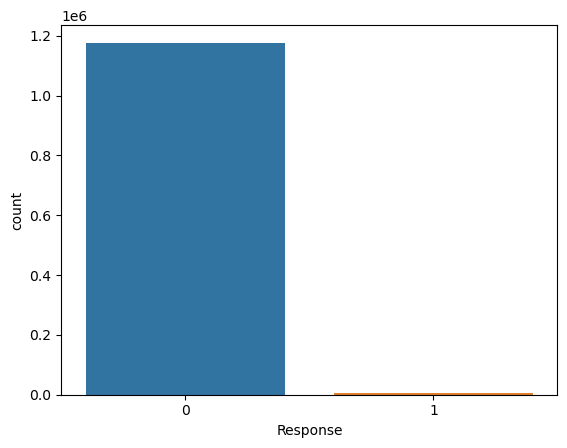

In [20]:
## On your Own
display(X_train.Response.value_counts()) # 0.995 : 0.005 = 995 : 5 = 199 : 1
sns.countplot(data=X_train, x="Response")

In [ ]:
# 이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

## 3. 데이터 전처리

Class Imbalance가 존재하는 경우에는 data sampling 기법을 이용하여 문제를 해결합니다.


- majority class : 다수가 속해있는 class


- minority class : 소수가 속해있는 class

<br>

1. Under sampling : majority class의 수를 minority class로 맞춰주기 위해서 random sampling을 수행하는 방법.

    e.g. 1176868 : 6879 -> 6879 : 6879

<br>

2. Over sampling : minority class에서 데이터를 생성하여 majority class의 수를 맞춰주는 방법.

    e.g. 1176868 : 6879 -> 1176868 : 1176868

<br>

3. Hybrid approach : under sampling & over sampling을 써서 적당한 수로 맞춰주는 방법.

    e.g. 1176868 : 6879 -> 20000 : 20000

In [21]:
# 모든 데이터가 NaN이라서, time_diff가 NaN이고 train_date에 아무 정보가 없는 데이터들을 제거합니다.
X_train = X_train.dropna() # 1183767 - 582
X_train

,Id,L0_S0_F4,L0_S0_F18,L0_S0_F20,L0_S1_F24,L0_S2_F36,L0_S2_F48,L0_S3_F80,L0_S5_F114,L0_S6_F122,...,L3_S30_F3684,L3_S30_F3749,L3_S30_F3764,L3_S33_F3855,L3_S35_F3896,L3_S36_F3918,Response,start_station,end_station,time_diff
0,4,-0.197,0.083,-0.273,-0.271,-0.023,0.001,0.000,0.000,0.000,...,0.000,-0.160,0.010,-0.119,-0.022,0.000,0,0,37,5.05
1,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.030,-0.143,0.012,-0.029,-0.028,0.000,0,12,37,2.63
2,7,0.003,-0.147,0.250,0.057,0.011,-0.005,0.000,-0.073,0.506,...,-0.013,-0.044,0.006,0.199,-0.091,0.000,0,0,37,5.72
3,9,0.294,-0.046,-0.253,0.147,0.120,0.005,0.000,0.000,0.000,...,0.029,0.147,0.013,0.017,0.000,-0.192,0,0,37,4.96
4,11,0.294,-0.099,0.042,-0.012,0.000,0.000,0.037,0.000,0.000,...,-0.011,0.070,0.010,-0.074,0.000,-0.092,0,0,37,3.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183742,2367490,-0.015,0.125,0.159,-0.084,-0.176,0.002,0.000,0.000,-0.311,...,-0.001,-0.046,0.009,-0.119,0.084,0.000,0,0,37,4.14
1183743,2367491,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.011,0.286,0.009,-0.210,0.000,-0.092,0,12,37,2.44
1183744,2367492,-0.343,0.051,0.046,0.057,0.000,0.000,-0.293,0.074,-0.287,...,-0.002,0.352,0.011,0.017,0.000,0.108,0,0,37,8.43
1183745,2367493,-0.179,0.275,0.156,-0.010,0.000,0.000,0.455,0.000,0.000,...,0.019,-0.032,0.011,0.062,-0.021,0.000,0,0,37,1.92


In [22]:
# 1) Undersampling
if sampling == 'under':
    N = 300000
    normal = X_train[X_train.Response == 0]
    abnormal = X_train[X_train.Response == 1]
    # do undersampling
    normal = normal.sample(n=N, random_state=42)
    print(normal.shape, abnormal.shape)
    
    temp = pd.concat([normal, abnormal])
    X_s = temp.drop(columns=["Id", "Response"])
    y_s = temp.Response

In [27]:
if sampling == 'over':
    # 2) Oversampling - SMOTE (only numeric features)
    from imblearn.over_sampling import SMOTE

    X = X_train.drop(columns=["Id", "Response"])
    y = X_train.Response

    X_s, y_s = SMOTE(random_state=42).fit_resample(X, y)
    print(X_s.shape, y_s.shape)

In [28]:
if sampling == 'hybrid':
    # 3) Hybrid approach
    N_sample = 20000
    normal = X_train[X_train.Response == 0].sample(n=N_sample, random_state=42) # 10000개 샘플
    abnormal = X_train[X_train.Response == 1]
    temp = pd.concat([normal, abnormal]) # 10000 + 6877

    from imblearn.over_sampling import SMOTE

    X = temp.drop(columns=["Id", "Response"])
    y = temp.Response

    X_s, y_s = SMOTE(random_state=42).fit_resample(X, y)
    print(X_s.shape, y_s.shape) # (20000, 43), (20000, )

(40000, 43) (40000,)


In [30]:
# after sampling, convert float to int.
X_s['start_station'] = X_s.start_station.astype(np.int8) # 64 -> 8 (reduce x8)
X_s['end_station'] = X_s.end_station.astype(np.int8)

## 4. 학습 데이터 분할

In [31]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = X_s
y = y_s

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(32000, 43) (8000, 43) (32000,) (8000,)


## 5. 학습 및 평가

In [32]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=20, max_depth=7, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=20, random_state=42)

In [33]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
from sklearn.metrics import matthews_corrcoef # MCC
evaluation_metric = matthews_corrcoef

In [34]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_val)

train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_val, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.5326
Test Score : 0.5122
